## Étape 1 : Charger les données

In [ ]:
import json
import pandas as pd

# Charger les données du fichier d'entraînement
# deals with smileys and special characters
df = pd.read_csv("data/train_submission.csv", sep="\t", encoding='utf-8')

# Afficher les premières lignes pour comprendre la structure
display(df.head())

# Transformer les données pour correspondre au format attendu
# Ici, nous supposons que le modèle doit être entraîné pour détecter les langues
df = df[['Text', 'Label']].rename(columns={'Text': 'text', 'Label': 'label'})

# # Charger les données de test
# test_df = pd.read_csv("data/test_without_labels.csv", sep="\t")

# display(test_df.head())



ParserError: Error tokenizing data. C error: Expected 1 fields in line 1966, saw 2


## Étape 2 : Préparer les données pour l'entraînement

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(
    df["text"], df["label"], test_size=0.2, random_state=42
)

# Vectoriser les phrases avec TF-IDF
vectorizer = TfidfVectorizer(stop_words="english", max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)


## Étape 3 : Entraîner un modèle de classification


In [3]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score

# Entraîner le modèle
model = MultinomialNB()
model.fit(X_train_tfidf, y_train, )

# Faire des prédictions
y_pred = model.predict(X_test_tfidf)

# Évaluer le modèle
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.8544776119402985
               precision    recall  f1-score   support

    Education       0.88      1.00      0.93        28
Entertainment       1.00      0.91      0.95        23
  Environment       0.54      0.91      0.68        22
      Fashion       0.93      0.93      0.93        30
      Finance       1.00      0.52      0.68        25
         Food       1.00      0.92      0.96        25
       Health       0.89      0.89      0.89        18
     Politics       0.96      1.00      0.98        24
      Science       0.91      0.53      0.67        19
       Sports       0.94      0.89      0.92        19
   Technology       0.92      0.73      0.81        15
       Travel       0.64      0.90      0.75        20

     accuracy                           0.85       268
    macro avg       0.88      0.84      0.85       268
 weighted avg       0.89      0.85      0.85       268



## Étape 4 : Tester le classificateur avec de nouvelles phrases

In [4]:
# Tester avec une nouvelle phrase
new_sentences = [
    "The government passed a new bill to regulate cryptocurrencies.",
    "The basketball player scored a record-breaking number of points.",
    "Artificial intelligence is changing the way we work."
]

new_sentences_tfidf = vectorizer.transform(new_sentences)
predictions = model.predict(new_sentences_tfidf)

for sentence, label in zip(new_sentences, predictions):
    print(f"'{sentence}' => {label}")


'The government passed a new bill to regulate cryptocurrencies.' => Politics
'The basketball player scored a record-breaking number of points.' => Sports
'Artificial intelligence is changing the way we work.' => Technology


## Étape 5 : Sauvegarder et charger le modèle (facultatif)

In [5]:
import joblib

# Sauvegarder le modèle et le vectoriseur
joblib.dump(model, "text_classifier_model.pkl")
joblib.dump(vectorizer, "vectorizer.pkl")

# Charger le modèle plus tard
loaded_model = joblib.load("text_classifier_model.pkl")
loaded_vectorizer = joblib.load("vectorizer.pkl")


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from collections import Counter
import numpy as np
import json

# Load and prepare the dataset
def load_data(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)
    
    sentences, labels = [], []
    for label, texts in data.items():
        sentences.extend(texts)
        labels.extend([label] * len(texts))
    return sentences, labels

# Tokenization and Vocabulary Building
def tokenize_and_build_vocab(sentences, min_freq=1):
    tokens = [word for sentence in sentences for word in sentence.split()]
    vocab_count = Counter(tokens)
    vocab = {word: idx + 1 for idx, (word, count) in enumerate(vocab_count.items()) if count >= min_freq}
    vocab["<UNK>"] = len(vocab) + 1
    vocab["<PAD>"] = 0
    return vocab

# Encode sentences into numerical format
def encode_sentences(sentences, vocab, max_len):
    encoded = []
    for sentence in sentences:
        encoded.append([vocab.get(word, vocab["<UNK>"]) for word in sentence.split()][:max_len])
    return [seq + [vocab["<PAD>"]] * (max_len - len(seq)) for seq in encoded]

# Custom Dataset Class
class TextDataset(Dataset):
    def __init__(self, sentences, labels):
        self.sentences = torch.tensor(sentences, dtype=torch.long)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.sentences[idx], self.labels[idx]

# LSTM Classifier
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        embedded = self.embedding(x)
        _, (hidden, _) = self.lstm(embedded)
        output = self.fc(hidden[-1])
        return output

# Main script
if __name__ == "__main__":
    # Parameters
    data_path = "data/test.json"
    embedding_dim = 100
    hidden_dim = 128
    batch_size = 32
    num_epochs = 10
    learning_rate = 0.001
    max_len = 50  # Max sequence length

    # Load data
    sentences, labels = load_data(data_path)

    # Encode labels
    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(labels)

    # Build vocabulary and encode sentences
    vocab = tokenize_and_build_vocab(sentences)
    encoded_sentences = encode_sentences(sentences, vocab, max_len)

    # Split data
    X_train, X_val, y_train, y_val = train_test_split(encoded_sentences, labels, test_size=0.2, random_state=42)

    # Create Datasets and DataLoaders
    train_dataset = TextDataset(X_train, y_train)
    val_dataset = TextDataset(X_val, y_val)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Model, Loss, Optimizer
    model = LSTMClassifier(vocab_size=len(vocab), embedding_dim=embedding_dim, hidden_dim=hidden_dim, num_classes=len(label_encoder.classes_))
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Training Loop
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for batch in train_loader:
            sentences, labels = batch
            optimizer.zero_grad()
            outputs = model(sentences)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss / len(train_loader):.4f}")

    # Evaluation
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in val_loader:
            sentences, labels = batch
            outputs = model(sentences)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Classification Report
    print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))


Epoch 1/10, Loss: 2.4852
Epoch 2/10, Loss: 2.4809
Epoch 3/10, Loss: 2.4795
Epoch 4/10, Loss: 2.4796
Epoch 5/10, Loss: 2.4801
Epoch 6/10, Loss: 2.4774
Epoch 7/10, Loss: 2.4779
Epoch 8/10, Loss: 2.4779
Epoch 9/10, Loss: 2.4783
Epoch 10/10, Loss: 2.4777
               precision    recall  f1-score   support

    Education       0.00      0.00      0.00        28
Entertainment       0.00      0.00      0.00        23
  Environment       0.08      1.00      0.15        22
      Fashion       0.00      0.00      0.00        30
      Finance       0.00      0.00      0.00        25
         Food       0.00      0.00      0.00        25
       Health       0.00      0.00      0.00        18
     Politics       0.00      0.00      0.00        24
      Science       0.00      0.00      0.00        19
       Sports       0.00      0.00      0.00        19
   Technology       0.00      0.00      0.00        15
       Travel       0.00      0.00      0.00        20

     accuracy                   

c:\Users\Martin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Martin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Martin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [6]:
# 1. Importation des bibliothèques nécessaires
import json
import torch
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset

# 2. Charger les données depuis le fichier JSON
with open("data/test.json", "r") as f:
    data = json.load(f)

# 3. Préparer les données pour l'entraînement
categories = list(data.keys())
texts = []
labels = []

for idx, category in enumerate(categories):
    for text in data[category]:
        texts.append(text)
        labels.append(idx)

# 4. Diviser les données en ensembles d'entraînement et de test
train_texts, test_texts, train_labels, test_labels = train_test_split(texts, labels, test_size=0.2)

# 5. Tokenisation avec BERT
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

train_data = {"text": train_texts, "label": train_labels}
test_data = {"text": test_texts, "label": test_labels}

train_dataset = Dataset.from_dict(train_data)
test_dataset = Dataset.from_dict(test_data)

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# 6. Initialiser le modèle BERT pour la classification
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(categories))

# 7. Configurer l'entraînement pour utiliser le GPU (CUDA si disponible)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 8. Configuration des paramètres d'entraînement
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
)

# 9. Initialiser le Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

# 10. Entraîner le modèle
trainer.train()

# 11. Évaluer le modèle
results = trainer.evaluate()
print(results)






tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

c:\Users\Martin\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Martin\.cache\huggingface\hub\models--bert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Map:   0%|          | 0/1070 [00:00<?, ? examples/s]

Map:   0%|          | 0/268 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\Martin\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


  0%|          | 0/201 [00:00<?, ?it/s]

{'loss': 2.3135, 'grad_norm': 6.739422798156738, 'learning_rate': 4.7512437810945275e-05, 'epoch': 0.15}
{'loss': 2.0406, 'grad_norm': 7.340625286102295, 'learning_rate': 4.502487562189055e-05, 'epoch': 0.3}
{'loss': 1.6809, 'grad_norm': 6.6272664070129395, 'learning_rate': 4.253731343283582e-05, 'epoch': 0.45}
{'loss': 1.4179, 'grad_norm': 5.652853965759277, 'learning_rate': 4.00497512437811e-05, 'epoch': 0.6}
{'loss': 1.0765, 'grad_norm': 5.040423393249512, 'learning_rate': 3.756218905472637e-05, 'epoch': 0.75}
{'loss': 0.8002, 'grad_norm': 7.126789093017578, 'learning_rate': 3.5074626865671645e-05, 'epoch': 0.9}


  0%|          | 0/17 [00:00<?, ?it/s]

{'eval_loss': 0.5019821524620056, 'eval_runtime': 6.3126, 'eval_samples_per_second': 42.455, 'eval_steps_per_second': 2.693, 'epoch': 1.0}
{'loss': 0.4748, 'grad_norm': 2.3734195232391357, 'learning_rate': 3.258706467661692e-05, 'epoch': 1.04}
{'loss': 0.3455, 'grad_norm': 4.336667537689209, 'learning_rate': 3.009950248756219e-05, 'epoch': 1.19}
{'loss': 0.2538, 'grad_norm': 3.422884941101074, 'learning_rate': 2.7611940298507467e-05, 'epoch': 1.34}
{'loss': 0.2108, 'grad_norm': 0.979602575302124, 'learning_rate': 2.512437810945274e-05, 'epoch': 1.49}
{'loss': 0.1943, 'grad_norm': 0.721481442451477, 'learning_rate': 2.2636815920398012e-05, 'epoch': 1.64}
{'loss': 0.108, 'grad_norm': 1.6990431547164917, 'learning_rate': 2.0149253731343285e-05, 'epoch': 1.79}
{'loss': 0.1358, 'grad_norm': 1.7070181369781494, 'learning_rate': 1.7661691542288558e-05, 'epoch': 1.94}


  0%|          | 0/17 [00:00<?, ?it/s]

{'eval_loss': 0.11231201887130737, 'eval_runtime': 6.341, 'eval_samples_per_second': 42.265, 'eval_steps_per_second': 2.681, 'epoch': 2.0}
{'loss': 0.0645, 'grad_norm': 0.5094209313392639, 'learning_rate': 1.5174129353233832e-05, 'epoch': 2.09}
{'loss': 0.0555, 'grad_norm': 0.41694745421409607, 'learning_rate': 1.2686567164179105e-05, 'epoch': 2.24}
{'loss': 0.0485, 'grad_norm': 0.36386728286743164, 'learning_rate': 1.0199004975124378e-05, 'epoch': 2.39}
{'loss': 0.0667, 'grad_norm': 0.3118654489517212, 'learning_rate': 7.711442786069652e-06, 'epoch': 2.54}
{'loss': 0.0435, 'grad_norm': 0.34932029247283936, 'learning_rate': 5.2238805970149255e-06, 'epoch': 2.69}
{'loss': 0.0409, 'grad_norm': 0.256906121969223, 'learning_rate': 2.736318407960199e-06, 'epoch': 2.84}
{'loss': 0.0398, 'grad_norm': 0.2693299651145935, 'learning_rate': 2.4875621890547267e-07, 'epoch': 2.99}


  0%|          | 0/17 [00:00<?, ?it/s]

{'eval_loss': 0.08012282848358154, 'eval_runtime': 7.5375, 'eval_samples_per_second': 35.556, 'eval_steps_per_second': 2.255, 'epoch': 3.0}
{'train_runtime': 244.6213, 'train_samples_per_second': 13.122, 'train_steps_per_second': 0.822, 'train_loss': 0.5679534016853541, 'epoch': 3.0}


  0%|          | 0/17 [00:00<?, ?it/s]

{'eval_loss': 0.08012282848358154, 'eval_runtime': 6.6343, 'eval_samples_per_second': 40.396, 'eval_steps_per_second': 2.562, 'epoch': 3.0}


In [5]:
!pip install tf-keras

   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ------------------------------------ --- 1.6/1.7 MB 9.3 MB/s eta 0:00:01
   ---------------------------------------- 1.7/1.7 MB 8.5 MB/s eta 0:00:00


In [7]:
# 12. Accuray et classification report
predictions = trainer.predict(test_dataset)
pred_labels = predictions.predictions.argmax(-1)
true_labels = test_dataset["label"]

accuracy = (pred_labels == true_labels).mean()
print(f"Accuracy: {accuracy}")

from sklearn.metrics import classification_report

print(classification_report(true_labels, pred_labels, target_names=categories))

  0%|          | 0/17 [00:00<?, ?it/s]

Accuracy: 0.9813432835820896
               precision    recall  f1-score   support

       Sports       1.00      1.00      1.00        21
   Technology       1.00      1.00      1.00        18
Entertainment       1.00      1.00      1.00        19
     Politics       1.00      1.00      1.00        18
       Health       1.00      1.00      1.00        23
      Finance       1.00      1.00      1.00        15
       Travel       0.96      1.00      0.98        24
         Food       0.94      1.00      0.97        30
    Education       1.00      1.00      1.00        17
  Environment       0.97      0.94      0.96        36
      Science       0.95      0.91      0.93        23
      Fashion       1.00      0.96      0.98        24

     accuracy                           0.98       268
    macro avg       0.99      0.98      0.98       268
 weighted avg       0.98      0.98      0.98       268



In [8]:
# 1. Importation des bibliothèques nécessaires
import json
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset

# 2. Charger les données depuis les fichiers JSON
with open("data/test.json", "r") as f:
    train_data_raw = json.load(f)

with open("data/train.json", "r") as f:
    test_data_raw = json.load(f)

# 3. Préparer les données pour l'entraînement
categories = list(train_data_raw.keys())
train_texts = []
train_labels = []
test_texts = []
test_labels = []

# Données d'entraînement
for idx, category in enumerate(categories):
    for text in train_data_raw[category]:
        train_texts.append(text)
        train_labels.append(idx)

# Données de test
for idx, category in enumerate(categories):
    if category in test_data_raw:  # Vérifier si la catégorie existe dans test.json
        for text in test_data_raw[category]:
            test_texts.append(text)
            test_labels.append(idx)

# 4. Tokenisation avec BERT
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

train_data = {"text": train_texts, "label": train_labels}
test_data = {"text": test_texts, "label": test_labels}

train_dataset = Dataset.from_dict(train_data)
test_dataset = Dataset.from_dict(test_data)

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# 5. Initialiser le modèle BERT pour la classification
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(categories))

# 6. Configurer l'entraînement pour utiliser le GPU (CUDA si disponible)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 7. Configuration des paramètres d'entraînement
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
)

# 8. Initialiser le Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

# 9. Entraîner le modèle
trainer.train()

# 10. Évaluer le modèle
results = trainer.evaluate()
print(results)


Map:   0%|          | 0/1338 [00:00<?, ? examples/s]

Map:   0%|          | 0/36 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\Martin\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


  0%|          | 0/420 [00:00<?, ?it/s]

{'loss': 2.5319, 'grad_norm': 5.353654861450195, 'learning_rate': 4.880952380952381e-05, 'epoch': 0.12}
{'loss': 2.2018, 'grad_norm': 6.196748733520508, 'learning_rate': 4.761904761904762e-05, 'epoch': 0.24}
{'loss': 1.8571, 'grad_norm': 6.36314058303833, 'learning_rate': 4.642857142857143e-05, 'epoch': 0.36}
{'loss': 1.4742, 'grad_norm': 5.408187389373779, 'learning_rate': 4.523809523809524e-05, 'epoch': 0.48}
{'loss': 1.087, 'grad_norm': 5.259101390838623, 'learning_rate': 4.404761904761905e-05, 'epoch': 0.6}
{'loss': 0.8482, 'grad_norm': 3.8894548416137695, 'learning_rate': 4.2857142857142856e-05, 'epoch': 0.71}
{'loss': 0.5601, 'grad_norm': 2.5930259227752686, 'learning_rate': 4.166666666666667e-05, 'epoch': 0.83}
{'loss': 0.3734, 'grad_norm': 4.404228210449219, 'learning_rate': 4.047619047619048e-05, 'epoch': 0.95}


  0%|          | 0/3 [00:00<?, ?it/s]

{'eval_loss': 0.9120021462440491, 'eval_runtime': 0.8697, 'eval_samples_per_second': 41.394, 'eval_steps_per_second': 3.45, 'epoch': 1.0}
{'loss': 0.2562, 'grad_norm': 1.7214550971984863, 'learning_rate': 3.928571428571429e-05, 'epoch': 1.07}
{'loss': 0.1447, 'grad_norm': 1.0728758573532104, 'learning_rate': 3.809523809523809e-05, 'epoch': 1.19}
{'loss': 0.1375, 'grad_norm': 0.9052480459213257, 'learning_rate': 3.690476190476191e-05, 'epoch': 1.31}
{'loss': 0.0757, 'grad_norm': 10.390039443969727, 'learning_rate': 3.571428571428572e-05, 'epoch': 1.43}
{'loss': 0.0786, 'grad_norm': 0.36810770630836487, 'learning_rate': 3.4523809523809526e-05, 'epoch': 1.55}
{'loss': 0.0676, 'grad_norm': 6.505331516265869, 'learning_rate': 3.3333333333333335e-05, 'epoch': 1.67}
{'loss': 0.0304, 'grad_norm': 0.25623783469200134, 'learning_rate': 3.2142857142857144e-05, 'epoch': 1.79}
{'loss': 0.0891, 'grad_norm': 0.18136845529079437, 'learning_rate': 3.095238095238095e-05, 'epoch': 1.9}


  0%|          | 0/3 [00:00<?, ?it/s]

{'eval_loss': 0.9200804829597473, 'eval_runtime': 0.8836, 'eval_samples_per_second': 40.743, 'eval_steps_per_second': 3.395, 'epoch': 2.0}
{'loss': 0.061, 'grad_norm': 0.18901412189006805, 'learning_rate': 2.9761904761904762e-05, 'epoch': 2.02}
{'loss': 0.0199, 'grad_norm': 0.32516440749168396, 'learning_rate': 2.857142857142857e-05, 'epoch': 2.14}
{'loss': 0.0179, 'grad_norm': 0.13689444959163666, 'learning_rate': 2.7380952380952383e-05, 'epoch': 2.26}
{'loss': 0.0406, 'grad_norm': 0.10144825279712677, 'learning_rate': 2.6190476190476192e-05, 'epoch': 2.38}
{'loss': 0.0156, 'grad_norm': 0.12227984517812729, 'learning_rate': 2.5e-05, 'epoch': 2.5}
{'loss': 0.0141, 'grad_norm': 0.09278393536806107, 'learning_rate': 2.380952380952381e-05, 'epoch': 2.62}
{'loss': 0.0131, 'grad_norm': 0.1250881552696228, 'learning_rate': 2.261904761904762e-05, 'epoch': 2.74}
{'loss': 0.0126, 'grad_norm': 0.08031081408262253, 'learning_rate': 2.1428571428571428e-05, 'epoch': 2.86}
{'loss': 0.0113, 'grad_nor

  0%|          | 0/3 [00:00<?, ?it/s]

{'eval_loss': 1.032590627670288, 'eval_runtime': 0.857, 'eval_samples_per_second': 42.008, 'eval_steps_per_second': 3.501, 'epoch': 3.0}
{'loss': 0.0107, 'grad_norm': 0.07638233155012131, 'learning_rate': 1.9047619047619046e-05, 'epoch': 3.1}
{'loss': 0.0099, 'grad_norm': 0.0737992525100708, 'learning_rate': 1.785714285714286e-05, 'epoch': 3.21}
{'loss': 0.0095, 'grad_norm': 0.06477619707584381, 'learning_rate': 1.6666666666666667e-05, 'epoch': 3.33}
{'loss': 0.0096, 'grad_norm': 0.06769085675477982, 'learning_rate': 1.5476190476190476e-05, 'epoch': 3.45}
{'loss': 0.0089, 'grad_norm': 0.06165656819939613, 'learning_rate': 1.4285714285714285e-05, 'epoch': 3.57}
{'loss': 0.0484, 'grad_norm': 0.06654931604862213, 'learning_rate': 1.3095238095238096e-05, 'epoch': 3.69}
{'loss': 0.0092, 'grad_norm': 0.06763788312673569, 'learning_rate': 1.1904761904761905e-05, 'epoch': 3.81}
{'loss': 0.0086, 'grad_norm': 0.06531181931495667, 'learning_rate': 1.0714285714285714e-05, 'epoch': 3.93}


  0%|          | 0/3 [00:00<?, ?it/s]

{'eval_loss': 1.115052580833435, 'eval_runtime': 0.8588, 'eval_samples_per_second': 41.921, 'eval_steps_per_second': 3.493, 'epoch': 4.0}
{'loss': 0.0082, 'grad_norm': 0.06005595996975899, 'learning_rate': 9.523809523809523e-06, 'epoch': 4.05}
{'loss': 0.0347, 'grad_norm': 0.06981071829795837, 'learning_rate': 8.333333333333334e-06, 'epoch': 4.17}
{'loss': 0.0079, 'grad_norm': 0.058254361152648926, 'learning_rate': 7.142857142857143e-06, 'epoch': 4.29}
{'loss': 0.0081, 'grad_norm': 0.06093908101320267, 'learning_rate': 5.9523809523809525e-06, 'epoch': 4.4}
{'loss': 0.0078, 'grad_norm': 0.0680793896317482, 'learning_rate': 4.7619047619047615e-06, 'epoch': 4.52}
{'loss': 0.0077, 'grad_norm': 0.050860848277807236, 'learning_rate': 3.5714285714285714e-06, 'epoch': 4.64}
{'loss': 0.0077, 'grad_norm': 0.06096892058849335, 'learning_rate': 2.3809523809523808e-06, 'epoch': 4.76}
{'loss': 0.0077, 'grad_norm': 0.05139569938182831, 'learning_rate': 1.1904761904761904e-06, 'epoch': 4.88}
{'loss': 

  0%|          | 0/3 [00:00<?, ?it/s]

{'eval_loss': 1.0868053436279297, 'eval_runtime': 1.0798, 'eval_samples_per_second': 33.338, 'eval_steps_per_second': 2.778, 'epoch': 5.0}
{'train_runtime': 463.5139, 'train_samples_per_second': 14.433, 'train_steps_per_second': 0.906, 'train_loss': 0.2912193606297175, 'epoch': 5.0}


  0%|          | 0/3 [00:00<?, ?it/s]

{'eval_loss': 1.0868053436279297, 'eval_runtime': 1.2104, 'eval_samples_per_second': 29.742, 'eval_steps_per_second': 2.478, 'epoch': 5.0}


In [9]:
# 12. Accuray et classification report
predictions = trainer.predict(test_dataset)
pred_labels = predictions.predictions.argmax(-1)
true_labels = test_dataset["label"]

accuracy = (pred_labels == true_labels).mean()
print(f"Accuracy: {accuracy}")

from sklearn.metrics import classification_report

print(classification_report(true_labels, pred_labels, target_names=categories))

  0%|          | 0/3 [00:00<?, ?it/s]

Accuracy: 0.7777777777777778
               precision    recall  f1-score   support

       Sports       0.60      1.00      0.75         3
   Technology       0.38      1.00      0.55         3
Entertainment       0.75      1.00      0.86         3
     Politics       1.00      1.00      1.00         3
       Health       1.00      1.00      1.00         3
      Finance       1.00      0.67      0.80         3
       Travel       1.00      1.00      1.00         3
         Food       1.00      0.67      0.80         3
    Education       0.00      0.00      0.00         3
  Environment       1.00      1.00      1.00         3
      Science       0.00      0.00      0.00         3
      Fashion       1.00      1.00      1.00         3

     accuracy                           0.78        36
    macro avg       0.73      0.78      0.73        36
 weighted avg       0.73      0.78      0.73        36



c:\Users\Martin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Martin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Martin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [ ]:
import json
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter


# # 1. Charger les données depuis les fichiers JSON
# with open("data/test.json", "r") as f:
#     train_data_raw = json.load(f)

# with open("data/train.json", "r") as f:
#     test_data_raw = json.load(f)

# Charger les données depuis les fichiers JSON
with open("data/test.json", "r") as f:
    test_data_raw = json.load(f)

# Charger les phrases de test à partir de test_shuffle.txt
test_texts = []
with open("data/test_shuffle.txt", "r") as f:
    test_texts = [line.strip() for line in f.readlines()]


# Préparer les données
categories = list(train_data_raw.keys())
train_texts, train_labels = [], []
# test_texts, test_labels = [], []

# Données d'entraînement
for category in categories:
    for text in train_data_raw[category]:
        train_texts.append(text)
        train_labels.append(category)

# Trouver les labels correspondant aux phrases de test
test_labels = []
for text in test_texts:
    found = False
    for category, texts in test_data_raw.items():
        if text in texts:
            test_labels.append(category)
            found = True
            break
    if not found:
        test_labels.append("Unknown")  # Cas où la phrase n'est pas trouvée, à ajuster si nécessaire

# Compter les labels inconnus
unknown_count = test_labels.count("Unknown")

# # Données de test
# for category in categories:
#     if category in test_data_raw:  # Vérifier si la catégorie existe dans test.json
#         for text in test_data_raw[category]:
#             test_texts.append(text)
#             test_labels.append(category)

# Split des données : Entraînement, Validation, Test
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_texts, train_labels, test_size=0.05, random_state=42
)

print(f"Training samples: {len(train_texts)}")
print(f"Validation samples: {len(val_texts)}")
print(f"Test samples: {len(test_texts)}")
print(f"Number of 'Unknown' labels: {unknown_count}")

# 2. Encodeur de labels
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_labels)
val_labels = label_encoder.transform(val_labels)
test_labels = label_encoder.transform(test_labels)

# 3. Tokenisation
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def tokenize_batch(batch):
    return tokenizer(batch, padding=True, truncation=True, max_length=128, return_tensors="pt")

class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

train_dataset = TextDataset(train_texts, train_labels)
val_dataset = TextDataset(val_texts, val_labels)
test_dataset = TextDataset(test_texts, test_labels)

# DataLoader
def collate_fn(batch):
    texts, labels = zip(*batch)
    tokenized = tokenize_batch(list(texts))
    return tokenized["input_ids"], tokenized["attention_mask"], torch.tensor(labels, dtype=torch.long)


train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=16, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=16, collate_fn=collate_fn)

# 4. Modèle DAN
class DANClassifier(nn.Module):
    def __init__(self, embedding_dim, num_classes):
        super(DANClassifier, self).__init__()
        self.embedding = nn.Embedding(tokenizer.vocab_size, embedding_dim)
        self.fc = nn.Sequential(
            nn.Linear(embedding_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )
    
    def forward(self, input_ids, attention_mask):
        embeddings = self.embedding(input_ids)  # Shape: (batch_size, seq_len, embedding_dim)
        mask = attention_mask.unsqueeze(-1)    # Shape: (batch_size, seq_len, 1)
        masked_embeddings = embeddings * mask  # Masquer les tokens de padding
        avg_embeddings = masked_embeddings.sum(dim=1) / mask.sum(dim=1)  # Moyenne des embeddings
        return self.fc(avg_embeddings)

# Initialiser le modèle
embedding_dim = 300
num_classes = len(categories)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = DANClassifier(embedding_dim, num_classes).to(device)

# 5. Optimisation et perte
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=2e-4)

# 6. Entraînement
def train_model_with_validation(model, train_loader, val_loader, optimizer, criterion, device, epochs=20):
    train_losses, val_losses, val_accuracies = [], [], []
    writer = SummaryWriter()  # Initialiser TensorBoard
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        correct, total = 0, 0
        
        for input_ids, attention_mask, labels in tqdm(train_loader):
            input_ids, attention_mask, labels = (
                input_ids.to(device),
                attention_mask.to(device),
                labels.to(device).long(),
            )
            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            train_loss += loss.item()
            loss.backward()
            optimizer.step()
            
            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        
        train_losses.append(train_loss / len(train_loader))
        train_accuracy = correct / total
        
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Accuracy: {train_accuracy:.4f}")
        
        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for input_ids, attention_mask, labels in val_loader:
                input_ids, attention_mask, labels = (
                    input_ids.to(device),
                    attention_mask.to(device),
                    labels.to(device).long(),
                )
                outputs = model(input_ids, attention_mask)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)
        
        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(val_correct / val_total)
        val_accuracy = val_correct / val_total
        print(f"Validation Loss: {val_losses[-1]:.4f}, Validation Accuracy: {val_accuracy:.4f}")
        
        # Enregistrer dans TensorBoard
        writer.add_scalar("Loss/Train", train_losses[-1], epoch + 1)
        writer.add_scalar("Loss/Validation", val_losses[-1], epoch + 1)
        writer.add_scalar("Accuracy/Validation", val_accuracies[-1], epoch + 1)
    
    writer.close()
    return train_losses, val_losses, val_accuracies

def plot_metrics(train_losses, val_losses, val_accuracies):
    epochs = range(1, len(train_losses) + 1)
    
    plt.figure(figsize=(12, 5))
    
    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss over Epochs")
    plt.legend()
    
    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_accuracies, label="Validation Accuracy", color="green")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Validation Accuracy over Epochs")
    plt.legend()
    
    plt.tight_layout()
    plt.show()


# Évaluation
def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    test_loss, correct, total = 0, 0, 0
    misclassified_samples = []  # Liste pour stocker les échantillons mal classifiés
    misclassified_labels = []   # Liste pour stocker les labels réels des échantillons mal classifiés
    misclassified_preds = []    # Liste pour stocker les labels prédits des échantillons mal classifiés

    with torch.no_grad():
        for input_ids, attention_mask, labels in tqdm(test_loader):
            input_ids, attention_mask, labels = (
                input_ids.to(device),
                attention_mask.to(device),
                labels.to(device).long(),
            )
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            
            # Capturer les échantillons mal classifiés
            misclassified_idx = (predicted != labels).nonzero(as_tuple=True)[0]
            for idx in misclassified_idx:
                misclassified_samples.append(input_ids[idx].cpu().numpy())  # Ajouter l'échantillon mal classifié
                misclassified_labels.append(labels[idx].cpu().item())      # Ajouter le label réel
                misclassified_preds.append(predicted[idx].cpu().item())     # Ajouter le label prédit
    
    accuracy = correct / total
    print(f"Test Loss: {test_loss / len(test_loader):.4f}, Test Accuracy: {accuracy:.4f}")
    
    return misclassified_samples, misclassified_labels, misclassified_preds


# Entraîner le modèle
train_losses, val_losses, val_accuracies = train_model_with_validation(
    model, train_loader, val_loader, optimizer, criterion, device
)

# Tracer les métriques
plot_metrics(train_losses, val_losses, val_accuracies)


# Évaluer le modèle et obtenir les échantillons mal classifiés
misclassified_samples, misclassified_labels, misclassified_preds = evaluate_model(
    model, test_loader, criterion, device
)

# print number of correctly classified samples (correctly classified samples / total test samples)
correctly_classified = len(test_labels) - len(misclassified_labels)
total_samples = len(test_labels)
print(f"Correctly classified samples: {correctly_classified}/{total_samples} ({correctly_classified / total_samples:.2%})")

# Décoder les indices des échantillons mal classifiés en texte
misclassified_texts = [tokenizer.decode(sample) for sample in misclassified_samples]

# Afficher les échantillons mal classifiés avec leurs labels réels et prédits
print("\n=== Misclassified Samples ===")
for i in range(len(misclassified_texts)):
    print(f"Text: {misclassified_texts[i][:100]}...")  # Afficher seulement les 100 premiers caractères pour plus de lisibilité
    real_label = label_encoder.inverse_transform([misclassified_labels[i]])[0]
    predicted_label = label_encoder.inverse_transform([misclassified_preds[i]])[0]
    print(f"True Label: {real_label}, Predicted Label: {predicted_label}")
    print("-" * 70)


# Visualiser quelques exemples
def show_samples(dataset, labels, label_encoder, n=5):
    print(f"{'Index':<10} {'Text':<50} {'Label'}")
    print("-" * 70)
    indices = random.sample(range(len(dataset)), n)
    for i in indices:
        category = label_encoder.inverse_transform([labels[i]])[0]  # Convertir label en nom de catégorie
        print(f"{i:<10} {dataset[i][:50]:<50} {category}")



print(f"\n=== Training Samples === (len: {len(train_texts)})")
show_samples(train_texts, train_labels, label_encoder, n=5)

print(f"\n=== Validation Samples === (len: {len(val_texts)})")
show_samples(val_texts, val_labels, label_encoder, n=5)

print(f"\n=== Test Samples === (len: {len(test_texts)})")
show_samples(test_texts, test_labels, label_encoder, n=5)




InvalidParameterError: The 'test_size' parameter of train_test_split must be a float in the range (0.0, 1.0), an int in the range [1, inf) or None. Got 0.0 instead.

## Sans Validation

In [20]:
# Charger les données depuis les fichiers JSON
with open("data/test.json", "r") as f:
    test_data_raw = json.load(f)

# Charger les phrases de test à partir de test_shuffle.txt
test_texts = []
with open("data/test_shuffle.txt", "r") as f:
    test_texts = [line.strip() for line in f.readlines()]

# Préparer les données
categories = list(train_data_raw.keys())
train_texts, train_labels = [], []

# Données d'entraînement
for category in categories:
    for text in train_data_raw[category]:
        train_texts.append(text)
        train_labels.append(category)

# Trouver les labels correspondant aux phrases de test
test_labels = []
for text in test_texts:
    found = False
    for category, texts in test_data_raw.items():
        if text in texts:
            test_labels.append(category)
            found = True
            break
    if not found:
        test_labels.append("Unknown")

# Compter les labels inconnus
unknown_count = test_labels.count("Unknown")

print(f"Training samples: {len(train_texts)}")
print(f"Test samples: {len(test_texts)}")
print(f"Number of 'Unknown' labels: {unknown_count}")

# Encodeur de labels
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_labels)
test_labels = label_encoder.transform(test_labels)

# Tokenisation
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def tokenize_batch(batch):
    return tokenizer(batch, padding=True, truncation=True, max_length=128, return_tensors="pt")

class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

train_dataset = TextDataset(train_texts, train_labels)
test_dataset = TextDataset(test_texts, test_labels)

def collate_fn(batch):
    texts, labels = zip(*batch)
    tokenized = tokenize_batch(list(texts))
    return tokenized["input_ids"], tokenized["attention_mask"], torch.tensor(labels, dtype=torch.long)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=16, collate_fn=collate_fn)

# Modèle DAN
class DANClassifier(nn.Module):
    def __init__(self, embedding_dim, num_classes):
        super(DANClassifier, self).__init__()
        self.embedding = nn.Embedding(tokenizer.vocab_size, embedding_dim)
        self.fc = nn.Sequential(
            nn.Linear(embedding_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, input_ids, attention_mask):
        embeddings = self.embedding(input_ids)
        mask = attention_mask.unsqueeze(-1)
        masked_embeddings = embeddings * mask
        avg_embeddings = masked_embeddings.sum(dim=1) / mask.sum(dim=1)
        return self.fc(avg_embeddings)

# Initialiser le modèle
embedding_dim = 300
num_classes = len(categories)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = DANClassifier(embedding_dim, num_classes).to(device)

# Optimisation et perte
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=2e-4)

# Entraînement
def train_model(model, train_loader, optimizer, criterion, device, epochs=20):
    train_losses = []
    writer = SummaryWriter()

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        correct, total = 0, 0

        for input_ids, attention_mask, labels in tqdm(train_loader):
            input_ids, attention_mask, labels = (
                input_ids.to(device),
                attention_mask.to(device),
                labels.to(device).long(),
            )
            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            train_loss += loss.item()
            loss.backward()
            optimizer.step()

            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_losses.append(train_loss / len(train_loader))
        train_accuracy = correct / total
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Accuracy: {train_accuracy:.4f}")

        # Enregistrer dans TensorBoard
        writer.add_scalar("Loss/Train", train_losses[-1], epoch + 1)
        writer.add_scalar("Accuracy/Train", train_accuracy, epoch + 1)

    writer.close()
    return train_losses

# Évaluation
def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    test_loss, correct, total = 0, 0, 0

    with torch.no_grad():
        for input_ids, attention_mask, labels in tqdm(test_loader):
            input_ids, attention_mask, labels = (
                input_ids.to(device),
                attention_mask.to(device),
                labels.to(device).long(),
            )
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    print(f"Test Loss: {test_loss / len(test_loader):.4f}, Test Accuracy: {accuracy:.4f}")

# Entraîner le modèle
train_losses = train_model(model, train_loader, optimizer, criterion, device, epochs=100)

# Évaluer le modèle
evaluate_model(model, test_loader, criterion, device)


Training samples: 1338
Test samples: 1140
Number of 'Unknown' labels: 0


100%|██████████| 84/84 [00:01<00:00, 79.79it/s] 


Epoch 1/100, Train Loss: 2.4271, Accuracy: 0.2138


100%|██████████| 84/84 [00:00<00:00, 126.12it/s]


Epoch 2/100, Train Loss: 2.2343, Accuracy: 0.4297


100%|██████████| 84/84 [00:00<00:00, 132.33it/s]


Epoch 3/100, Train Loss: 1.9396, Accuracy: 0.6009


100%|██████████| 84/84 [00:00<00:00, 124.33it/s]


Epoch 4/100, Train Loss: 1.6623, Accuracy: 0.6584


100%|██████████| 84/84 [00:00<00:00, 132.06it/s]


Epoch 5/100, Train Loss: 1.4170, Accuracy: 0.7384


100%|██████████| 84/84 [00:00<00:00, 132.75it/s]


Epoch 6/100, Train Loss: 1.1980, Accuracy: 0.8049


100%|██████████| 84/84 [00:00<00:00, 125.40it/s]


Epoch 7/100, Train Loss: 1.0154, Accuracy: 0.8401


100%|██████████| 84/84 [00:00<00:00, 131.85it/s]


Epoch 8/100, Train Loss: 0.8742, Accuracy: 0.8505


100%|██████████| 84/84 [00:00<00:00, 132.10it/s]


Epoch 9/100, Train Loss: 0.7561, Accuracy: 0.8797


100%|██████████| 84/84 [00:00<00:00, 132.47it/s]


Epoch 10/100, Train Loss: 0.6422, Accuracy: 0.8939


100%|██████████| 84/84 [00:00<00:00, 131.39it/s]


Epoch 11/100, Train Loss: 0.5658, Accuracy: 0.9081


100%|██████████| 84/84 [00:00<00:00, 132.94it/s]


Epoch 12/100, Train Loss: 0.4926, Accuracy: 0.9185


100%|██████████| 84/84 [00:00<00:00, 132.06it/s]


Epoch 13/100, Train Loss: 0.4315, Accuracy: 0.9305


100%|██████████| 84/84 [00:00<00:00, 129.92it/s]


Epoch 14/100, Train Loss: 0.3867, Accuracy: 0.9350


100%|██████████| 84/84 [00:00<00:00, 134.15it/s]


Epoch 15/100, Train Loss: 0.3567, Accuracy: 0.9395


100%|██████████| 84/84 [00:00<00:00, 130.67it/s]


Epoch 16/100, Train Loss: 0.3123, Accuracy: 0.9462


100%|██████████| 84/84 [00:00<00:00, 133.25it/s]


Epoch 17/100, Train Loss: 0.2905, Accuracy: 0.9529


100%|██████████| 84/84 [00:00<00:00, 128.18it/s]


Epoch 18/100, Train Loss: 0.2528, Accuracy: 0.9544


100%|██████████| 84/84 [00:00<00:00, 119.49it/s]


Epoch 19/100, Train Loss: 0.2320, Accuracy: 0.9656


100%|██████████| 84/84 [00:00<00:00, 133.30it/s]


Epoch 20/100, Train Loss: 0.2076, Accuracy: 0.9634


100%|██████████| 84/84 [00:00<00:00, 131.82it/s]


Epoch 21/100, Train Loss: 0.1932, Accuracy: 0.9649


100%|██████████| 84/84 [00:00<00:00, 129.12it/s]


Epoch 22/100, Train Loss: 0.1766, Accuracy: 0.9738


100%|██████████| 84/84 [00:00<00:00, 129.15it/s]


Epoch 23/100, Train Loss: 0.1621, Accuracy: 0.9731


100%|██████████| 84/84 [00:00<00:00, 132.36it/s]


Epoch 24/100, Train Loss: 0.1450, Accuracy: 0.9791


100%|██████████| 84/84 [00:00<00:00, 129.61it/s]


Epoch 25/100, Train Loss: 0.1304, Accuracy: 0.9821


100%|██████████| 84/84 [00:00<00:00, 134.05it/s]


Epoch 26/100, Train Loss: 0.1191, Accuracy: 0.9828


100%|██████████| 84/84 [00:00<00:00, 133.30it/s]


Epoch 27/100, Train Loss: 0.1114, Accuracy: 0.9895


100%|██████████| 84/84 [00:00<00:00, 130.09it/s]


Epoch 28/100, Train Loss: 0.1049, Accuracy: 0.9858


100%|██████████| 84/84 [00:00<00:00, 130.35it/s]


Epoch 29/100, Train Loss: 0.0911, Accuracy: 0.9888


100%|██████████| 84/84 [00:00<00:00, 129.31it/s]


Epoch 30/100, Train Loss: 0.0917, Accuracy: 0.9880


100%|██████████| 84/84 [00:00<00:00, 134.17it/s]


Epoch 31/100, Train Loss: 0.0811, Accuracy: 0.9918


100%|██████████| 84/84 [00:00<00:00, 128.02it/s]


Epoch 32/100, Train Loss: 0.0753, Accuracy: 0.9918


100%|██████████| 84/84 [00:00<00:00, 124.45it/s]


Epoch 33/100, Train Loss: 0.0693, Accuracy: 0.9940


100%|██████████| 84/84 [00:00<00:00, 131.02it/s]


Epoch 34/100, Train Loss: 0.0667, Accuracy: 0.9933


100%|██████████| 84/84 [00:00<00:00, 128.94it/s]


Epoch 35/100, Train Loss: 0.0583, Accuracy: 0.9970


100%|██████████| 84/84 [00:00<00:00, 121.23it/s]


Epoch 36/100, Train Loss: 0.0569, Accuracy: 0.9955


100%|██████████| 84/84 [00:00<00:00, 125.18it/s]


Epoch 37/100, Train Loss: 0.0506, Accuracy: 0.9940


100%|██████████| 84/84 [00:00<00:00, 128.04it/s]


Epoch 38/100, Train Loss: 0.0485, Accuracy: 0.9955


100%|██████████| 84/84 [00:00<00:00, 131.00it/s]


Epoch 39/100, Train Loss: 0.0478, Accuracy: 0.9955


100%|██████████| 84/84 [00:00<00:00, 133.82it/s]


Epoch 40/100, Train Loss: 0.0442, Accuracy: 0.9955


100%|██████████| 84/84 [00:00<00:00, 128.72it/s]


Epoch 41/100, Train Loss: 0.0406, Accuracy: 0.9970


100%|██████████| 84/84 [00:00<00:00, 132.76it/s]


Epoch 42/100, Train Loss: 0.0387, Accuracy: 0.9978


100%|██████████| 84/84 [00:00<00:00, 117.83it/s]


Epoch 43/100, Train Loss: 0.0358, Accuracy: 0.9970


100%|██████████| 84/84 [00:00<00:00, 128.58it/s]


Epoch 44/100, Train Loss: 0.0356, Accuracy: 0.9970


100%|██████████| 84/84 [00:00<00:00, 129.99it/s]


Epoch 45/100, Train Loss: 0.0336, Accuracy: 0.9955


100%|██████████| 84/84 [00:00<00:00, 115.79it/s]


Epoch 46/100, Train Loss: 0.0303, Accuracy: 0.9978


100%|██████████| 84/84 [00:00<00:00, 118.65it/s]


Epoch 47/100, Train Loss: 0.0268, Accuracy: 0.9993


100%|██████████| 84/84 [00:00<00:00, 110.27it/s]


Epoch 48/100, Train Loss: 0.0261, Accuracy: 1.0000


100%|██████████| 84/84 [00:00<00:00, 116.59it/s]


Epoch 49/100, Train Loss: 0.0240, Accuracy: 0.9985


100%|██████████| 84/84 [00:00<00:00, 126.05it/s]


Epoch 50/100, Train Loss: 0.0240, Accuracy: 0.9985


100%|██████████| 84/84 [00:00<00:00, 114.48it/s]


Epoch 51/100, Train Loss: 0.0219, Accuracy: 0.9993


100%|██████████| 84/84 [00:00<00:00, 127.94it/s]


Epoch 52/100, Train Loss: 0.0216, Accuracy: 0.9993


100%|██████████| 84/84 [00:00<00:00, 117.12it/s]


Epoch 53/100, Train Loss: 0.0193, Accuracy: 0.9993


100%|██████████| 84/84 [00:00<00:00, 112.27it/s]


Epoch 54/100, Train Loss: 0.0185, Accuracy: 0.9993


100%|██████████| 84/84 [00:00<00:00, 109.83it/s]


Epoch 55/100, Train Loss: 0.0173, Accuracy: 0.9993


100%|██████████| 84/84 [00:00<00:00, 113.32it/s]


Epoch 56/100, Train Loss: 0.0177, Accuracy: 0.9993


100%|██████████| 84/84 [00:00<00:00, 109.01it/s]


Epoch 57/100, Train Loss: 0.0146, Accuracy: 0.9993


100%|██████████| 84/84 [00:00<00:00, 122.32it/s]


Epoch 58/100, Train Loss: 0.0141, Accuracy: 1.0000


100%|██████████| 84/84 [00:00<00:00, 113.01it/s]


Epoch 59/100, Train Loss: 0.0152, Accuracy: 0.9993


100%|██████████| 84/84 [00:00<00:00, 113.69it/s]


Epoch 60/100, Train Loss: 0.0130, Accuracy: 1.0000


100%|██████████| 84/84 [00:00<00:00, 110.34it/s]


Epoch 61/100, Train Loss: 0.0115, Accuracy: 1.0000


100%|██████████| 84/84 [00:00<00:00, 114.39it/s]


Epoch 62/100, Train Loss: 0.0100, Accuracy: 1.0000


100%|██████████| 84/84 [00:00<00:00, 121.60it/s]


Epoch 63/100, Train Loss: 0.0119, Accuracy: 1.0000


100%|██████████| 84/84 [00:00<00:00, 115.51it/s]


Epoch 64/100, Train Loss: 0.0097, Accuracy: 1.0000


100%|██████████| 84/84 [00:00<00:00, 108.04it/s]


Epoch 65/100, Train Loss: 0.0114, Accuracy: 1.0000


100%|██████████| 84/84 [00:00<00:00, 113.86it/s]


Epoch 66/100, Train Loss: 0.0098, Accuracy: 0.9985


100%|██████████| 84/84 [00:00<00:00, 110.64it/s]


Epoch 67/100, Train Loss: 0.0099, Accuracy: 1.0000


100%|██████████| 84/84 [00:00<00:00, 113.79it/s]


Epoch 68/100, Train Loss: 0.0084, Accuracy: 1.0000


100%|██████████| 84/84 [00:00<00:00, 116.45it/s]


Epoch 69/100, Train Loss: 0.0074, Accuracy: 1.0000


100%|██████████| 84/84 [00:00<00:00, 115.25it/s]


Epoch 70/100, Train Loss: 0.0092, Accuracy: 1.0000


100%|██████████| 84/84 [00:00<00:00, 113.91it/s]


Epoch 71/100, Train Loss: 0.0075, Accuracy: 0.9993


100%|██████████| 84/84 [00:00<00:00, 117.03it/s]


Epoch 72/100, Train Loss: 0.0070, Accuracy: 1.0000


100%|██████████| 84/84 [00:00<00:00, 104.80it/s]


Epoch 73/100, Train Loss: 0.0079, Accuracy: 0.9993


100%|██████████| 84/84 [00:00<00:00, 115.32it/s]


Epoch 74/100, Train Loss: 0.0061, Accuracy: 1.0000


100%|██████████| 84/84 [00:00<00:00, 114.29it/s]


Epoch 75/100, Train Loss: 0.0076, Accuracy: 0.9993


100%|██████████| 84/84 [00:00<00:00, 118.93it/s]


Epoch 76/100, Train Loss: 0.0059, Accuracy: 1.0000


100%|██████████| 84/84 [00:00<00:00, 115.22it/s]


Epoch 77/100, Train Loss: 0.0054, Accuracy: 1.0000


100%|██████████| 84/84 [00:00<00:00, 116.11it/s]


Epoch 78/100, Train Loss: 0.0043, Accuracy: 1.0000


100%|██████████| 84/84 [00:00<00:00, 107.20it/s]


Epoch 79/100, Train Loss: 0.0057, Accuracy: 1.0000


100%|██████████| 84/84 [00:00<00:00, 108.30it/s]


Epoch 80/100, Train Loss: 0.0056, Accuracy: 1.0000


100%|██████████| 84/84 [00:00<00:00, 111.94it/s]


Epoch 81/100, Train Loss: 0.0052, Accuracy: 1.0000


100%|██████████| 84/84 [00:00<00:00, 118.48it/s]


Epoch 82/100, Train Loss: 0.0054, Accuracy: 1.0000


100%|██████████| 84/84 [00:00<00:00, 121.55it/s]


Epoch 83/100, Train Loss: 0.0042, Accuracy: 1.0000


100%|██████████| 84/84 [00:00<00:00, 121.64it/s]


Epoch 84/100, Train Loss: 0.0047, Accuracy: 1.0000


100%|██████████| 84/84 [00:00<00:00, 123.55it/s]


Epoch 85/100, Train Loss: 0.0038, Accuracy: 1.0000


100%|██████████| 84/84 [00:00<00:00, 121.76it/s]


Epoch 86/100, Train Loss: 0.0035, Accuracy: 1.0000


100%|██████████| 84/84 [00:00<00:00, 122.26it/s]


Epoch 87/100, Train Loss: 0.0041, Accuracy: 1.0000


100%|██████████| 84/84 [00:00<00:00, 118.87it/s]


Epoch 88/100, Train Loss: 0.0041, Accuracy: 1.0000


100%|██████████| 84/84 [00:00<00:00, 130.43it/s]


Epoch 89/100, Train Loss: 0.0032, Accuracy: 1.0000


100%|██████████| 84/84 [00:00<00:00, 122.20it/s]


Epoch 90/100, Train Loss: 0.0027, Accuracy: 1.0000


100%|██████████| 84/84 [00:01<00:00, 42.92it/s]


Epoch 91/100, Train Loss: 0.0025, Accuracy: 1.0000


100%|██████████| 84/84 [00:02<00:00, 38.13it/s]


Epoch 92/100, Train Loss: 0.0031, Accuracy: 1.0000


100%|██████████| 84/84 [00:02<00:00, 39.61it/s]


Epoch 93/100, Train Loss: 0.0028, Accuracy: 1.0000


100%|██████████| 84/84 [00:02<00:00, 40.19it/s]


Epoch 94/100, Train Loss: 0.0023, Accuracy: 1.0000


100%|██████████| 84/84 [00:02<00:00, 39.92it/s]


Epoch 95/100, Train Loss: 0.0029, Accuracy: 1.0000


100%|██████████| 84/84 [00:01<00:00, 48.49it/s]


Epoch 96/100, Train Loss: 0.0025, Accuracy: 1.0000


100%|██████████| 84/84 [00:02<00:00, 35.23it/s]


Epoch 97/100, Train Loss: 0.0030, Accuracy: 1.0000


100%|██████████| 84/84 [00:00<00:00, 100.34it/s]


Epoch 98/100, Train Loss: 0.0029, Accuracy: 1.0000


100%|██████████| 84/84 [00:00<00:00, 99.44it/s] 


Epoch 99/100, Train Loss: 0.0029, Accuracy: 1.0000


100%|██████████| 84/84 [00:00<00:00, 98.77it/s] 


Epoch 100/100, Train Loss: 0.0020, Accuracy: 1.0000


100%|██████████| 72/72 [00:00<00:00, 186.48it/s]

Test Loss: 0.0008, Test Accuracy: 1.0000


## avec switch validation ou pas

In [21]:
import csv
import json
import torch
from tqdm import tqdm

# Effectuer des prédictions sur le jeu de test
def predict_and_verify(model, test_loader, device, label_encoder):
    model.eval()
    predictions = []
    true_labels = []
    all_correct = True  # Vérification si toutes les prédictions sont correctes

    with torch.no_grad():
        for input_ids, attention_mask, labels in tqdm(test_loader):
            input_ids, attention_mask = input_ids.to(device), attention_mask.to(device)
            outputs = model(input_ids, attention_mask)
            _, predicted = outputs.max(1)
            predictions.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    # Vérification des prédictions
    for i in range(len(predictions)):
        if predictions[i] != true_labels[i]:
            all_correct = False
            print(f"Mismatch at index {i}: Predicted = {label_encoder.inverse_transform([predictions[i]])[0]}, "
                  f"True = {label_encoder.inverse_transform([true_labels[i]])[0]}")

    if all_correct:
        print("All predictions are correct!")
    else:
        print("Some predictions are incorrect. Please check the output above.")

    return predictions, true_labels, all_correct

# Générer un fichier CSV pour Kaggle
def generate_kaggle_csv(predictions, file_path, private_every_other=True):
    with open(file_path, "w", newline="") as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["ID", "Usage", "Label"])

        for i, prediction in enumerate(predictions):
            usage = "Private" if private_every_other and i % 2 == 1 else "Public"
            writer.writerow([i, usage, prediction])

    print(f"Kaggle submission file saved to {file_path}")

# Effectuer des prédictions et vérifier les résultats
predictions, true_labels, all_correct = predict_and_verify(model, test_loader, device, label_encoder)

# Décoder les prédictions en catégories
decoded_predictions = label_encoder.inverse_transform(predictions)

# Générer le fichier CSV pour Kaggle
generate_kaggle_csv(decoded_predictions, "submission_kaggle.csv")


100%|██████████| 72/72 [00:00<00:00, 220.46it/s]

All predictions are correct!
Kaggle submission file saved to submission_kaggle.csv


Training samples: 1338
Validation samples: 0
Test samples: 1140
Number of 'Unknown' labels: 0


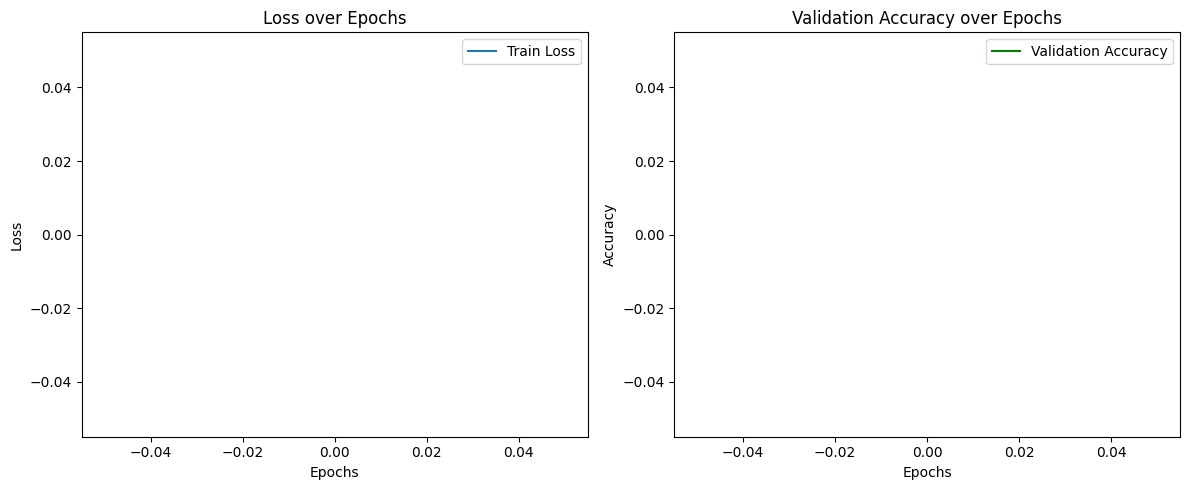

100%|██████████| 72/72 [00:00<00:00, 144.95it/s]


Test Loss: 2.4839, Test Accuracy: 0.0860
Correctly classified samples: 98/1140 (8.60%)

=== Misclassified Samples ===
Text: [CLS] the role of credit scores in lending decisions is significant. [SEP] [PAD] [PAD] [PAD] [PAD] [...
True Label: Finance, Predicted Label: Environment
----------------------------------------------------------------------
Text: [CLS] the impact of overpopulation on the environment is a topic of ongoing research. [SEP] [PAD] [P...
True Label: Environment, Predicted Label: Technology
----------------------------------------------------------------------
Text: [CLS] the importance of the scientific method in conducting research cannot be overemphasized. [SEP]...
True Label: Science, Predicted Label: Technology
----------------------------------------------------------------------
Text: [CLS] the startup accelerator provides funding and mentorship to help early - stage companies grow. ...
True Label: Technology, Predicted Label: Entertainment
----------------------

In [ ]:
import json
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter

# Charger les données depuis les fichiers JSON
with open("data/test.json", "r") as f:
    test_data_raw = json.load(f)

# Charger les phrases de test à partir de test_shuffle.txt
test_texts = []
with open("data/test_shuffle.txt", "r") as f:
    test_texts = [line.strip() for line in f.readlines()]

# Paramètre pour déterminer si un set de validation est utilisé
use_validation = False  # Changez cette valeur à False si vous ne voulez pas de validation

# Préparer les données
categories = list(test_data_raw.keys())
train_texts, train_labels = [], []
# Données d'entraînement
for category in categories:
    for text in test_data_raw[category]:
        train_texts.append(text)
        train_labels.append(category)

# Trouver les labels correspondant aux phrases de test
test_labels = []
for text in test_texts:
    found = False
    for category, texts in test_data_raw.items():
        if text in texts:
            test_labels.append(category)
            found = True
            break
    if not found:
        test_labels.append("Unknown")  # Cas où la phrase n'est pas trouvée, à ajuster si nécessaire

# Compter les labels inconnus
unknown_count = test_labels.count("Unknown")

# Split des données : Entraînement, Validation, Test
if use_validation:
    train_texts, val_texts, train_labels, val_labels = train_test_split(
        train_texts, train_labels, test_size=0.05, random_state=42
    )
    print(f"Training samples: {len(train_texts)}")
    print(f"Validation samples: {len(val_texts)}")
else:
    val_texts, val_labels = [], []  # Si pas de validation, on met des listes vides pour éviter des erreurs
    print(f"Training samples: {len(train_texts)}")
    print(f"Validation samples: 0")

print(f"Test samples: {len(test_texts)}")
print(f"Number of 'Unknown' labels: {unknown_count}")

# 2. Encodeur de labels
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_labels)
if use_validation:
    val_labels = label_encoder.transform(val_labels)
test_labels = label_encoder.transform(test_labels)

# 3. Tokenisation
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def tokenize_batch(batch):
    return tokenizer(batch, padding=True, truncation=True, max_length=128, return_tensors="pt")

class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

train_dataset = TextDataset(train_texts, train_labels)
val_dataset = TextDataset(val_texts, val_labels) if use_validation else None
test_dataset = TextDataset(test_texts, test_labels)

# DataLoader
def collate_fn(batch):
    texts, labels = zip(*batch)
    tokenized = tokenize_batch(list(texts))
    return tokenized["input_ids"], tokenized["attention_mask"], torch.tensor(labels, dtype=torch.long)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=16, collate_fn=collate_fn) if use_validation else None
test_loader = DataLoader(test_dataset, batch_size=16, collate_fn=collate_fn)

# 4. Modèle DAN
class DANClassifier(nn.Module):
    def __init__(self, embedding_dim, num_classes):
        super(DANClassifier, self).__init__()
        self.embedding = nn.Embedding(tokenizer.vocab_size, embedding_dim)
        self.fc = nn.Sequential(
            nn.Linear(embedding_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )
    
    def forward(self, input_ids, attention_mask):
        embeddings = self.embedding(input_ids)  # Shape: (batch_size, seq_len, embedding_dim)
        mask = attention_mask.unsqueeze(-1)    # Shape: (batch_size, seq_len, 1)
        masked_embeddings = embeddings * mask  # Masquer les tokens de padding
        avg_embeddings = masked_embeddings.sum(dim=1) / mask.sum(dim=1)  # Moyenne des embeddings
        return self.fc(avg_embeddings)

# Initialiser le modèle
embedding_dim = 300
num_classes = len(categories)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = DANClassifier(embedding_dim, num_classes).to(device)

# 5. Optimisation et perte
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=2e-4)

# 6. Entraînement
def train_model_with_validation(model, train_loader, val_loader, optimizer, criterion, device, epochs=20):
    train_losses, val_losses, val_accuracies = [], [], []
    writer = SummaryWriter()  # Initialiser TensorBoard
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        correct, total = 0, 0
        
        for input_ids, attention_mask, labels in tqdm(train_loader):
            input_ids, attention_mask, labels = (
                input_ids.to(device),
                attention_mask.to(device),
                labels.to(device).long(),
            )
            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            train_loss += loss.item()
            loss.backward()
            optimizer.step()
            
            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        
        train_losses.append(train_loss / len(train_loader))
        train_accuracy = correct / total
        
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Accuracy: {train_accuracy:.4f}")
        
        # Validation
        if use_validation:
            model.eval()
            val_loss, val_correct, val_total = 0, 0, 0
            with torch.no_grad():
                for input_ids, attention_mask, labels in val_loader:
                    input_ids, attention_mask, labels = (
                        input_ids.to(device),
                        attention_mask.to(device),
                        labels.to(device).long(),
                    )
                    outputs = model(input_ids, attention_mask)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()
                    _, predicted = outputs.max(1)
                    val_correct += (predicted == labels).sum().item()
                    val_total += labels.size(0)
            
            val_losses.append(val_loss / len(val_loader))
            val_accuracies.append(val_correct / val_total)
            val_accuracy = val_correct / val_total
            print(f"Validation Loss: {val_losses[-1]:.4f}, Validation Accuracy: {val_accuracy:.4f}")
        
            # Enregistrer dans TensorBoard
            writer.add_scalar("Loss/Train", train_losses[-1], epoch + 1)
            writer.add_scalar("Loss/Validation", val_losses[-1], epoch + 1)
            writer.add_scalar("Accuracy/Validation", val_accuracies[-1], epoch + 1)
    
    writer.close()
    return train_losses, val_losses, val_accuracies

# Entraîner le modèle avec ou sans validation
if use_validation:
    train_losses, val_losses, val_accuracies = train_model_with_validation(
        model, train_loader, val_loader, optimizer, criterion, device
    )

else:
    train_losses = []
    val_losses = []
    val_accuracies = []

    # Tracer les métriques
    plot_metrics(train_losses, val_losses, val_accuracies)


# Évaluer le modèle et obtenir les échantillons mal classifiés
misclassified_samples, misclassified_labels, misclassified_preds = evaluate_model(
    model, test_loader, criterion, device
)

# print number of correctly classified samples (correctly classified samples / total test samples)
correctly_classified = len(test_labels) - len(misclassified_labels)
total_samples = len(test_labels)
print(f"Correctly classified samples: {correctly_classified}/{total_samples} ({correctly_classified / total_samples:.2%})")

# Décoder les indices des échantillons mal classifiés en texte
misclassified_texts = [tokenizer.decode(sample) for sample in misclassified_samples]

# Afficher les échantillons mal classifiés avec leurs labels réels et prédits
print("\n=== Misclassified Samples ===")
for i in range(len(misclassified_texts)):
    print(f"Text: {misclassified_texts[i][:100]}...")  # Afficher seulement les 100 premiers caractères pour plus de lisibilité
    real_label = label_encoder.inverse_transform([misclassified_labels[i]])[0]
    predicted_label = label_encoder.inverse_transform([misclassified_preds[i]])[0]
    print(f"True Label: {real_label}, Predicted Label: {predicted_label}")
    print("-" * 70)


# Visualiser quelques exemples
def show_samples(dataset, labels, label_encoder, n=5):
    print(f"{'Index':<10} {'Text':<50} {'Label'}")
    print("-" * 70)
    indices = random.sample(range(len(dataset)), n)
    for i in indices:
        category = label_encoder.inverse_transform([labels[i]])[0]  # Convertir label en nom de catégorie
        print(f"{i:<10} {dataset[i][:50]:<50} {category}")



print(f"\n=== Training Samples === (len: {len(train_texts)})")
show_samples(train_texts, train_labels, label_encoder, n=5)

if use_validation:
    print(f"\n=== Validation Samples === (len: {len(val_texts)})")
    show_samples(val_texts, val_labels, label_encoder, n=5)

print(f"\n=== Test Samples === (len: {len(test_texts)})")
show_samples(test_texts, test_labels, label_encoder, n=5)


## Avec cross validation

In [16]:
import json
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter


# Charger les données depuis les fichiers JSON
with open("data/test.json", "r") as f:
    test_data_raw = json.load(f)

# Charger les phrases de test à partir de test_shuffle.txt
test_texts = []
with open("data/test_shuffle.txt", "r") as f:
    test_texts = [line.strip() for line in f.readlines()]


# Préparer les données
categories = list(test_data_raw.keys())
train_texts, train_labels = [], []
for category in categories:
    for text in test_data_raw[category]:
        train_texts.append(text)
        train_labels.append(category)

# Trouver les labels correspondant aux phrases de test
test_labels = []
for text in test_texts:
    found = False
    for category, texts in test_data_raw.items():
        if text in texts:
            test_labels.append(category)
            found = True
            break
    if not found:
        test_labels.append("Unknown")

# len
print(f"Training samples: {len(train_texts)}")
print(f"Test samples: {len(test_texts)}")
print(f"Number of 'Unknown' labels: {test_labels.count('Unknown')}")

# Encodeur de labels
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_labels)
test_labels = label_encoder.transform(test_labels)

# Tokenisation
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def tokenize_batch(batch):
    return tokenizer(batch, padding=True, truncation=True, max_length=128, return_tensors="pt")

class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

# DataLoader
def collate_fn(batch):
    texts, labels = zip(*batch)
    tokenized = tokenize_batch(list(texts))
    return tokenized["input_ids"], tokenized["attention_mask"], torch.tensor(labels, dtype=torch.long)

# Modèle DAN
class DANClassifier(nn.Module):
    def __init__(self, embedding_dim, num_classes):
        super(DANClassifier, self).__init__()
        self.embedding = nn.Embedding(tokenizer.vocab_size, embedding_dim)
        self.fc = nn.Sequential(
            nn.Linear(embedding_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )
    
    def forward(self, input_ids, attention_mask):
        embeddings = self.embedding(input_ids)  # Shape: (batch_size, seq_len, embedding_dim)
        mask = attention_mask.unsqueeze(-1)    # Shape: (batch_size, seq_len, 1)
        masked_embeddings = embeddings * mask  # Masquer les tokens de padding
        avg_embeddings = masked_embeddings.sum(dim=1) / mask.sum(dim=1)  # Moyenne des embeddings
        return self.fc(avg_embeddings)

# Fonction d'entraînement et de validation
def train_and_validate(model, train_loader, val_loader, optimizer, criterion, device):
    model.train()
    train_loss = 0
    correct, total = 0, 0
    
    for input_ids, attention_mask, labels in tqdm(train_loader):
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device).long()
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        
        _, predicted = outputs.max(1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    
    train_accuracy = correct / total
    
    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for input_ids, attention_mask, labels in val_loader:
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device).long()
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)
    
    val_accuracy = val_correct / val_total
    return train_loss / len(train_loader), train_accuracy, val_loss / len(val_loader), val_accuracy

# Fonction de validation croisée
def cross_validate(k_folds, train_texts, train_labels, model_class, embedding_dim, num_classes, epochs=20):
    kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    fold_train_losses, fold_val_losses = [], []
    fold_train_accuracies, fold_val_accuracies = [] , []  # Correction ici

    for fold, (train_idx, val_idx) in enumerate(kfold.split(train_texts)):
        print(f"\nFold {fold + 1}/{k_folds}")
        train_texts_fold = [train_texts[i] for i in train_idx]
        train_labels_fold = [train_labels[i] for i in train_idx]
        val_texts_fold = [train_texts[i] for i in val_idx]
        val_labels_fold = [train_labels[i] for i in val_idx]

        # Préparer les datasets pour le fold
        train_dataset = TextDataset(train_texts_fold, train_labels_fold)
        val_dataset = TextDataset(val_texts_fold, val_labels_fold)
        train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
        val_loader = DataLoader(val_dataset, batch_size=16, collate_fn=collate_fn)

        # Initialiser le modèle pour le fold
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = model_class(embedding_dim, num_classes).to(device)
        optimizer = optim.Adam(model.parameters(), lr=2e-4)
        criterion = nn.CrossEntropyLoss()

        # Entraîner le modèle pour le fold
        train_losses, val_losses, val_accuracies = train_model_with_validation(
            model, train_loader, val_loader, optimizer, criterion, device, epochs=epochs
        )

        # Collecter les métriques pour ce fold
        fold_train_losses.append(train_losses)
        fold_val_losses.append(val_losses)
        fold_val_accuracies.append(val_accuracies)

    print("\n=== Résultats des différents folds ===")
    for fold in range(k_folds):
        print(
            f"Fold {fold + 1}: Validation Accuracy: {fold_val_accuracies[fold][-1]:.4f}, "
            f"Validation Loss: {fold_val_losses[fold][-1]:.4f}"
        )

# Appeler la validation croisée avec 5 folds
k_folds = 5
embedding_dim = 300
num_classes = len(categories)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cross_validate(k_folds, train_texts, train_labels, DANClassifier, embedding_dim, num_classes, epochs=20)

# Évaluer le modèle et obtenir les échantillons mal classifiés
misclassified_samples, misclassified_labels, misclassified_preds = evaluate_model(
    model, test_loader, criterion, device
)

# print number of correctly classified samples (correctly classified samples / total test samples)
correctly_classified = len(test_labels) - len(misclassified_labels)
total_samples = len(test_labels)
print(f"Correctly classified samples: {correctly_classified}/{total_samples} ({correctly_classified / total_samples:.2%})")

# Décoder les indices des échantillons mal classifiés en texte
misclassified_texts = [tokenizer.decode(sample) for sample in misclassified_samples]


Training samples: 1338
Test samples: 1140
Number of 'Unknown' labels: 0

Fold 1/5


100%|██████████| 67/67 [00:00<00:00, 76.95it/s] 


Epoch 1/20, Train Loss: 2.4433, Accuracy: 0.1794
Validation Loss: 2.3722, Validation Accuracy: 0.5112


100%|██████████| 67/67 [00:00<00:00, 119.79it/s]


Epoch 2/20, Train Loss: 2.3167, Accuracy: 0.4710
Validation Loss: 2.2272, Validation Accuracy: 0.6418


100%|██████████| 67/67 [00:00<00:00, 127.20it/s]


Epoch 3/20, Train Loss: 2.1388, Accuracy: 0.6019
Validation Loss: 2.0253, Validation Accuracy: 0.6791


100%|██████████| 67/67 [00:00<00:00, 128.31it/s]


Epoch 4/20, Train Loss: 1.9166, Accuracy: 0.6477
Validation Loss: 1.7884, Validation Accuracy: 0.7351


100%|██████████| 67/67 [00:00<00:00, 125.29it/s]


Epoch 5/20, Train Loss: 1.6920, Accuracy: 0.6935
Validation Loss: 1.5622, Validation Accuracy: 0.7537


100%|██████████| 67/67 [00:00<00:00, 130.90it/s]


Epoch 6/20, Train Loss: 1.4708, Accuracy: 0.7505
Validation Loss: 1.3575, Validation Accuracy: 0.7687


100%|██████████| 67/67 [00:00<00:00, 133.34it/s]


Epoch 7/20, Train Loss: 1.2675, Accuracy: 0.7841
Validation Loss: 1.1812, Validation Accuracy: 0.8134


100%|██████████| 67/67 [00:00<00:00, 129.44it/s]


Epoch 8/20, Train Loss: 1.1060, Accuracy: 0.8290
Validation Loss: 1.0353, Validation Accuracy: 0.8284


100%|██████████| 67/67 [00:00<00:00, 134.42it/s]


Epoch 9/20, Train Loss: 0.9684, Accuracy: 0.8449
Validation Loss: 0.9109, Validation Accuracy: 0.8433


100%|██████████| 67/67 [00:00<00:00, 132.62it/s]


Epoch 10/20, Train Loss: 0.8286, Accuracy: 0.8804
Validation Loss: 0.8034, Validation Accuracy: 0.8507


100%|██████████| 67/67 [00:00<00:00, 129.58it/s]


Epoch 11/20, Train Loss: 0.7439, Accuracy: 0.8841
Validation Loss: 0.7192, Validation Accuracy: 0.8881


100%|██████████| 67/67 [00:00<00:00, 132.71it/s]


Epoch 12/20, Train Loss: 0.6542, Accuracy: 0.9065
Validation Loss: 0.6474, Validation Accuracy: 0.8843


100%|██████████| 67/67 [00:00<00:00, 129.88it/s]


Epoch 13/20, Train Loss: 0.5756, Accuracy: 0.9131
Validation Loss: 0.5941, Validation Accuracy: 0.8918


100%|██████████| 67/67 [00:00<00:00, 131.09it/s]


Epoch 14/20, Train Loss: 0.5252, Accuracy: 0.9103
Validation Loss: 0.5332, Validation Accuracy: 0.9179


100%|██████████| 67/67 [00:00<00:00, 132.93it/s]


Epoch 15/20, Train Loss: 0.4479, Accuracy: 0.9402
Validation Loss: 0.4957, Validation Accuracy: 0.9216


100%|██████████| 67/67 [00:00<00:00, 133.15it/s]


Epoch 16/20, Train Loss: 0.4143, Accuracy: 0.9383
Validation Loss: 0.4595, Validation Accuracy: 0.9216


100%|██████████| 67/67 [00:00<00:00, 120.60it/s]


Epoch 17/20, Train Loss: 0.3784, Accuracy: 0.9477
Validation Loss: 0.4277, Validation Accuracy: 0.9291


100%|██████████| 67/67 [00:00<00:00, 132.36it/s]


Epoch 18/20, Train Loss: 0.3517, Accuracy: 0.9523
Validation Loss: 0.3984, Validation Accuracy: 0.9291


100%|██████████| 67/67 [00:00<00:00, 118.69it/s]


Epoch 19/20, Train Loss: 0.3046, Accuracy: 0.9542
Validation Loss: 0.3759, Validation Accuracy: 0.9328


100%|██████████| 67/67 [00:00<00:00, 130.40it/s]


Epoch 20/20, Train Loss: 0.2780, Accuracy: 0.9579
Validation Loss: 0.3575, Validation Accuracy: 0.9328

Fold 2/5


100%|██████████| 67/67 [00:00<00:00, 132.51it/s]


Epoch 1/20, Train Loss: 2.4283, Accuracy: 0.1841
Validation Loss: 2.3722, Validation Accuracy: 0.2575


100%|██████████| 67/67 [00:00<00:00, 131.49it/s]


Epoch 2/20, Train Loss: 2.2925, Accuracy: 0.3841
Validation Loss: 2.2113, Validation Accuracy: 0.5187


100%|██████████| 67/67 [00:00<00:00, 124.48it/s]


Epoch 3/20, Train Loss: 2.1003, Accuracy: 0.5598
Validation Loss: 2.0075, Validation Accuracy: 0.6828


100%|██████████| 67/67 [00:00<00:00, 129.77it/s]


Epoch 4/20, Train Loss: 1.8778, Accuracy: 0.6673
Validation Loss: 1.7772, Validation Accuracy: 0.7276


100%|██████████| 67/67 [00:00<00:00, 133.73it/s]


Epoch 5/20, Train Loss: 1.6471, Accuracy: 0.7383
Validation Loss: 1.5587, Validation Accuracy: 0.8134


100%|██████████| 67/67 [00:00<00:00, 131.63it/s]


Epoch 6/20, Train Loss: 1.4365, Accuracy: 0.7673
Validation Loss: 1.3575, Validation Accuracy: 0.8284


100%|██████████| 67/67 [00:00<00:00, 132.82it/s]


Epoch 7/20, Train Loss: 1.2509, Accuracy: 0.8131
Validation Loss: 1.1849, Validation Accuracy: 0.8433


100%|██████████| 67/67 [00:00<00:00, 132.09it/s]


Epoch 8/20, Train Loss: 1.0858, Accuracy: 0.8421
Validation Loss: 1.0385, Validation Accuracy: 0.8545


100%|██████████| 67/67 [00:00<00:00, 133.77it/s]


Epoch 9/20, Train Loss: 0.9508, Accuracy: 0.8523
Validation Loss: 0.9155, Validation Accuracy: 0.8582


100%|██████████| 67/67 [00:00<00:00, 132.74it/s]


Epoch 10/20, Train Loss: 0.8290, Accuracy: 0.8720
Validation Loss: 0.8120, Validation Accuracy: 0.8731


100%|██████████| 67/67 [00:00<00:00, 130.94it/s]


Epoch 11/20, Train Loss: 0.7319, Accuracy: 0.8776
Validation Loss: 0.7248, Validation Accuracy: 0.8769


100%|██████████| 67/67 [00:00<00:00, 132.83it/s]


Epoch 12/20, Train Loss: 0.6487, Accuracy: 0.8944
Validation Loss: 0.6544, Validation Accuracy: 0.8918


100%|██████████| 67/67 [00:00<00:00, 134.79it/s]


Epoch 13/20, Train Loss: 0.5670, Accuracy: 0.9112
Validation Loss: 0.5985, Validation Accuracy: 0.8843


100%|██████████| 67/67 [00:00<00:00, 131.38it/s]


Epoch 14/20, Train Loss: 0.5156, Accuracy: 0.9168
Validation Loss: 0.5517, Validation Accuracy: 0.8918


100%|██████████| 67/67 [00:00<00:00, 130.69it/s]


Epoch 15/20, Train Loss: 0.4686, Accuracy: 0.9327
Validation Loss: 0.5108, Validation Accuracy: 0.8993


100%|██████████| 67/67 [00:00<00:00, 132.23it/s]


Epoch 16/20, Train Loss: 0.4107, Accuracy: 0.9318
Validation Loss: 0.4746, Validation Accuracy: 0.8993


100%|██████████| 67/67 [00:00<00:00, 128.87it/s]


Epoch 17/20, Train Loss: 0.3784, Accuracy: 0.9411
Validation Loss: 0.4451, Validation Accuracy: 0.9030


100%|██████████| 67/67 [00:00<00:00, 132.27it/s]


Epoch 18/20, Train Loss: 0.3434, Accuracy: 0.9364
Validation Loss: 0.4188, Validation Accuracy: 0.9179


100%|██████████| 67/67 [00:00<00:00, 129.77it/s]


Epoch 19/20, Train Loss: 0.3055, Accuracy: 0.9579
Validation Loss: 0.3975, Validation Accuracy: 0.9067


100%|██████████| 67/67 [00:00<00:00, 131.90it/s]


Epoch 20/20, Train Loss: 0.2779, Accuracy: 0.9542
Validation Loss: 0.3777, Validation Accuracy: 0.9179

Fold 3/5


100%|██████████| 67/67 [00:00<00:00, 133.04it/s]


Epoch 1/20, Train Loss: 2.4504, Accuracy: 0.1991
Validation Loss: 2.4066, Validation Accuracy: 0.3545


100%|██████████| 67/67 [00:00<00:00, 131.58it/s]


Epoch 2/20, Train Loss: 2.3246, Accuracy: 0.4467
Validation Loss: 2.2646, Validation Accuracy: 0.5336


100%|██████████| 67/67 [00:00<00:00, 123.88it/s]


Epoch 3/20, Train Loss: 2.1490, Accuracy: 0.5346
Validation Loss: 2.0621, Validation Accuracy: 0.6082


100%|██████████| 67/67 [00:00<00:00, 133.39it/s]


Epoch 4/20, Train Loss: 1.9137, Accuracy: 0.6299
Validation Loss: 1.8199, Validation Accuracy: 0.6903


100%|██████████| 67/67 [00:00<00:00, 134.13it/s]


Epoch 5/20, Train Loss: 1.6848, Accuracy: 0.6841
Validation Loss: 1.5940, Validation Accuracy: 0.7612


100%|██████████| 67/67 [00:00<00:00, 125.28it/s]


Epoch 6/20, Train Loss: 1.4502, Accuracy: 0.7645
Validation Loss: 1.3978, Validation Accuracy: 0.7948


100%|██████████| 67/67 [00:00<00:00, 132.19it/s]


Epoch 7/20, Train Loss: 1.2647, Accuracy: 0.7944
Validation Loss: 1.2234, Validation Accuracy: 0.8134


100%|██████████| 67/67 [00:00<00:00, 131.39it/s]


Epoch 8/20, Train Loss: 1.0974, Accuracy: 0.8196
Validation Loss: 1.0811, Validation Accuracy: 0.8396


100%|██████████| 67/67 [00:00<00:00, 127.86it/s]


Epoch 9/20, Train Loss: 0.9582, Accuracy: 0.8458
Validation Loss: 0.9581, Validation Accuracy: 0.8396


100%|██████████| 67/67 [00:00<00:00, 134.76it/s]


Epoch 10/20, Train Loss: 0.8360, Accuracy: 0.8710
Validation Loss: 0.8586, Validation Accuracy: 0.8545


100%|██████████| 67/67 [00:00<00:00, 129.15it/s]


Epoch 11/20, Train Loss: 0.7475, Accuracy: 0.8729
Validation Loss: 0.7808, Validation Accuracy: 0.8769


100%|██████████| 67/67 [00:00<00:00, 129.95it/s]


Epoch 12/20, Train Loss: 0.6535, Accuracy: 0.8972
Validation Loss: 0.7086, Validation Accuracy: 0.8694


100%|██████████| 67/67 [00:00<00:00, 129.93it/s]


Epoch 13/20, Train Loss: 0.5854, Accuracy: 0.9075
Validation Loss: 0.6455, Validation Accuracy: 0.8806


100%|██████████| 67/67 [00:00<00:00, 131.05it/s]


Epoch 14/20, Train Loss: 0.5195, Accuracy: 0.9215
Validation Loss: 0.5947, Validation Accuracy: 0.8918


100%|██████████| 67/67 [00:00<00:00, 130.52it/s]


Epoch 15/20, Train Loss: 0.4776, Accuracy: 0.9262
Validation Loss: 0.5531, Validation Accuracy: 0.9030


100%|██████████| 67/67 [00:00<00:00, 133.97it/s]


Epoch 16/20, Train Loss: 0.4382, Accuracy: 0.9346
Validation Loss: 0.5233, Validation Accuracy: 0.8918


100%|██████████| 67/67 [00:00<00:00, 132.96it/s]


Epoch 17/20, Train Loss: 0.3917, Accuracy: 0.9346
Validation Loss: 0.4888, Validation Accuracy: 0.8993


100%|██████████| 67/67 [00:00<00:00, 129.05it/s]


Epoch 18/20, Train Loss: 0.3493, Accuracy: 0.9495
Validation Loss: 0.4583, Validation Accuracy: 0.9030


100%|██████████| 67/67 [00:00<00:00, 132.91it/s]


Epoch 19/20, Train Loss: 0.3143, Accuracy: 0.9607
Validation Loss: 0.4366, Validation Accuracy: 0.9104


100%|██████████| 67/67 [00:00<00:00, 133.59it/s]


Epoch 20/20, Train Loss: 0.2924, Accuracy: 0.9617
Validation Loss: 0.4203, Validation Accuracy: 0.9104

Fold 4/5


100%|██████████| 67/67 [00:00<00:00, 128.79it/s]


Epoch 1/20, Train Loss: 2.4459, Accuracy: 0.1755
Validation Loss: 2.3818, Validation Accuracy: 0.4045


100%|██████████| 67/67 [00:00<00:00, 130.80it/s]


Epoch 2/20, Train Loss: 2.3092, Accuracy: 0.4239
Validation Loss: 2.2273, Validation Accuracy: 0.5993


100%|██████████| 67/67 [00:00<00:00, 122.43it/s]


Epoch 3/20, Train Loss: 2.1125, Accuracy: 0.5929
Validation Loss: 2.0171, Validation Accuracy: 0.6217


100%|██████████| 67/67 [00:00<00:00, 131.70it/s]


Epoch 4/20, Train Loss: 1.8823, Accuracy: 0.6415
Validation Loss: 1.7900, Validation Accuracy: 0.7041


100%|██████████| 67/67 [00:00<00:00, 133.17it/s]


Epoch 5/20, Train Loss: 1.6547, Accuracy: 0.6975
Validation Loss: 1.5747, Validation Accuracy: 0.7678


100%|██████████| 67/67 [00:00<00:00, 130.73it/s]


Epoch 6/20, Train Loss: 1.4263, Accuracy: 0.7479
Validation Loss: 1.3718, Validation Accuracy: 0.8015


100%|██████████| 67/67 [00:00<00:00, 134.08it/s]


Epoch 7/20, Train Loss: 1.2441, Accuracy: 0.7852
Validation Loss: 1.2012, Validation Accuracy: 0.8352


100%|██████████| 67/67 [00:00<00:00, 133.48it/s]


Epoch 8/20, Train Loss: 1.0744, Accuracy: 0.8217
Validation Loss: 1.0538, Validation Accuracy: 0.8352


100%|██████████| 67/67 [00:00<00:00, 133.25it/s]


Epoch 9/20, Train Loss: 0.9422, Accuracy: 0.8525
Validation Loss: 0.9315, Validation Accuracy: 0.8577


100%|██████████| 67/67 [00:00<00:00, 131.01it/s]


Epoch 10/20, Train Loss: 0.8373, Accuracy: 0.8618
Validation Loss: 0.8306, Validation Accuracy: 0.8652


100%|██████████| 67/67 [00:00<00:00, 130.22it/s]


Epoch 11/20, Train Loss: 0.7304, Accuracy: 0.8870
Validation Loss: 0.7436, Validation Accuracy: 0.8652


100%|██████████| 67/67 [00:00<00:00, 130.16it/s]


Epoch 12/20, Train Loss: 0.6436, Accuracy: 0.8982
Validation Loss: 0.6728, Validation Accuracy: 0.8801


100%|██████████| 67/67 [00:00<00:00, 133.18it/s]


Epoch 13/20, Train Loss: 0.5671, Accuracy: 0.9066
Validation Loss: 0.6131, Validation Accuracy: 0.8839


100%|██████████| 67/67 [00:00<00:00, 133.89it/s]


Epoch 14/20, Train Loss: 0.5232, Accuracy: 0.9066
Validation Loss: 0.5619, Validation Accuracy: 0.8839


100%|██████████| 67/67 [00:00<00:00, 126.73it/s]


Epoch 15/20, Train Loss: 0.4749, Accuracy: 0.9197
Validation Loss: 0.5217, Validation Accuracy: 0.8876


100%|██████████| 67/67 [00:00<00:00, 132.99it/s]


Epoch 16/20, Train Loss: 0.4314, Accuracy: 0.9262
Validation Loss: 0.4841, Validation Accuracy: 0.8989


100%|██████████| 67/67 [00:00<00:00, 133.27it/s]


Epoch 17/20, Train Loss: 0.3932, Accuracy: 0.9384
Validation Loss: 0.4546, Validation Accuracy: 0.8989


100%|██████████| 67/67 [00:00<00:00, 126.87it/s]


Epoch 18/20, Train Loss: 0.3518, Accuracy: 0.9412
Validation Loss: 0.4246, Validation Accuracy: 0.9101


100%|██████████| 67/67 [00:00<00:00, 131.45it/s]


Epoch 19/20, Train Loss: 0.3178, Accuracy: 0.9477
Validation Loss: 0.4038, Validation Accuracy: 0.9064


100%|██████████| 67/67 [00:00<00:00, 132.28it/s]


Epoch 20/20, Train Loss: 0.2928, Accuracy: 0.9496
Validation Loss: 0.3844, Validation Accuracy: 0.9139

Fold 5/5


100%|██████████| 67/67 [00:00<00:00, 128.57it/s]


Epoch 1/20, Train Loss: 2.4471, Accuracy: 0.1895
Validation Loss: 2.3874, Validation Accuracy: 0.3933


100%|██████████| 67/67 [00:00<00:00, 132.49it/s]


Epoch 2/20, Train Loss: 2.3109, Accuracy: 0.4641
Validation Loss: 2.2447, Validation Accuracy: 0.5431


100%|██████████| 67/67 [00:00<00:00, 124.73it/s]


Epoch 3/20, Train Loss: 2.1180, Accuracy: 0.5920
Validation Loss: 2.0453, Validation Accuracy: 0.5955


100%|██████████| 67/67 [00:00<00:00, 133.37it/s]


Epoch 4/20, Train Loss: 1.8880, Accuracy: 0.6573
Validation Loss: 1.8213, Validation Accuracy: 0.6517


100%|██████████| 67/67 [00:00<00:00, 130.94it/s]


Epoch 5/20, Train Loss: 1.6333, Accuracy: 0.7162
Validation Loss: 1.6084, Validation Accuracy: 0.6854


100%|██████████| 67/67 [00:00<00:00, 130.29it/s]


Epoch 6/20, Train Loss: 1.4198, Accuracy: 0.7554
Validation Loss: 1.4242, Validation Accuracy: 0.7041


100%|██████████| 67/67 [00:00<00:00, 131.94it/s]


Epoch 7/20, Train Loss: 1.2416, Accuracy: 0.7843
Validation Loss: 1.2611, Validation Accuracy: 0.7191


100%|██████████| 67/67 [00:00<00:00, 132.70it/s]


Epoch 8/20, Train Loss: 1.0912, Accuracy: 0.8105
Validation Loss: 1.1236, Validation Accuracy: 0.7603


100%|██████████| 67/67 [00:00<00:00, 130.88it/s]


Epoch 9/20, Train Loss: 0.9502, Accuracy: 0.8394
Validation Loss: 1.0037, Validation Accuracy: 0.7865


100%|██████████| 67/67 [00:00<00:00, 130.60it/s]


Epoch 10/20, Train Loss: 0.8338, Accuracy: 0.8581
Validation Loss: 0.9063, Validation Accuracy: 0.8052


100%|██████████| 67/67 [00:00<00:00, 133.16it/s]


Epoch 11/20, Train Loss: 0.7364, Accuracy: 0.8814
Validation Loss: 0.8190, Validation Accuracy: 0.8127


100%|██████████| 67/67 [00:00<00:00, 127.93it/s]


Epoch 12/20, Train Loss: 0.6464, Accuracy: 0.8954
Validation Loss: 0.7492, Validation Accuracy: 0.8277


100%|██████████| 67/67 [00:00<00:00, 134.49it/s]


Epoch 13/20, Train Loss: 0.5800, Accuracy: 0.9057
Validation Loss: 0.6856, Validation Accuracy: 0.8390


100%|██████████| 67/67 [00:00<00:00, 133.80it/s]


Epoch 14/20, Train Loss: 0.5146, Accuracy: 0.9337
Validation Loss: 0.6332, Validation Accuracy: 0.8427


100%|██████████| 67/67 [00:00<00:00, 131.12it/s]


Epoch 15/20, Train Loss: 0.4620, Accuracy: 0.9225
Validation Loss: 0.5868, Validation Accuracy: 0.8464


100%|██████████| 67/67 [00:00<00:00, 133.88it/s]


Epoch 16/20, Train Loss: 0.4280, Accuracy: 0.9300
Validation Loss: 0.5491, Validation Accuracy: 0.8464


100%|██████████| 67/67 [00:00<00:00, 134.08it/s]


Epoch 17/20, Train Loss: 0.3737, Accuracy: 0.9449
Validation Loss: 0.5091, Validation Accuracy: 0.8577


100%|██████████| 67/67 [00:00<00:00, 128.28it/s]


Epoch 18/20, Train Loss: 0.3505, Accuracy: 0.9421
Validation Loss: 0.4849, Validation Accuracy: 0.8614


100%|██████████| 67/67 [00:00<00:00, 134.04it/s]


Epoch 19/20, Train Loss: 0.3217, Accuracy: 0.9412
Validation Loss: 0.4567, Validation Accuracy: 0.8727


100%|██████████| 67/67 [00:00<00:00, 133.55it/s]


Epoch 20/20, Train Loss: 0.2839, Accuracy: 0.9524
Validation Loss: 0.4356, Validation Accuracy: 0.8727

=== Résultats des différents folds ===
Fold 1: Validation Accuracy: 0.9328, Validation Loss: 0.3575
Fold 2: Validation Accuracy: 0.9179, Validation Loss: 0.3777
Fold 3: Validation Accuracy: 0.9104, Validation Loss: 0.4203
Fold 4: Validation Accuracy: 0.9139, Validation Loss: 0.3844
Fold 5: Validation Accuracy: 0.8727, Validation Loss: 0.4356


100%|██████████| 72/72 [00:00<00:00, 260.48it/s]

Test Loss: 0.1834, Test Accuracy: 0.9798
Correctly classified samples: 1117/1140 (97.98%)
